In [1]:
import os
import re
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import editdistance
from collections import Counter

from tqdm import notebook as tqdm
import sys; sys.path.insert(0, "..")
from program_synthesis.analysis.load_results import *
from program_synthesis.analysis.organize_results import *
from program_synthesis.analysis.models_to_analyze import model_labels
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
accuracies = [table_of_accuracies(x, pbar=tqdm.tqdm) for x in model_labels]
accuracies = pd.concat(accuracies)

vanilla



vanilla-123-old



vanilla-123-old-real-nearai-finetuned-1e-4



vanilla-123-old-real-nearai32-finetuned-1e-4



vanilla-123-old-finetuned-agg-start-with-finetuned



vanilla-1-old



vanilla-1-old-real-nearai-finetuned-1e-4



aggregate-with-io



vanilla-real-nearai-finetuned-1e-4



aggregate-with-io-real-nearai-finetuned-1e-4



vanilla-many-mutations



aggregate-with-io-many-mutations



vanilla-real-nearai32-finetuned-1e-4



aggregate-with-io-real-nearai32-finetuned-1e-4


In [4]:
real_acs = get_for_baseline_models(accuracies, "nearai", "nearai32", "egnps64")

In [5]:
topline = separate_strategies(real_acs)
topline.to_csv("/home/kavigupta/topline.csv")

vanilla-many-mutations nearai,,greedy,,50
vanilla-many-mutations nearai,,greedy,,100
vanilla-many-mutations nearai,,greedy,,200
vanilla-many-mutations nearai,,best_first,,50
vanilla-many-mutations nearai,,best_first,,100
vanilla-many-mutations nearai,,best_first,,200
vanilla-123-old nearai,,greedy,,100
vanilla-123-old nearai,,greedy,,200
vanilla-123-old nearai,,best_first,,200
vanilla-1-old nearai,,best_first,,1
vanilla-1-old nearai,,greedy,,5
vanilla-1-old nearai,,greedy,,10
vanilla-1-old nearai,,greedy,,25
vanilla-1-old nearai,,greedy,,50
vanilla-1-old nearai,,greedy,,100
vanilla-1-old nearai,,greedy,,200
vanilla-1-old nearai,,best_first,,1
vanilla-1-old nearai,,best_first,,5
vanilla-1-old nearai,,best_first,,10
vanilla-1-old nearai,,best_first,,25
vanilla-1-old nearai,,best_first,,50
vanilla-1-old nearai,,best_first,,100
vanilla-1-old nearai,,best_first,,200
vanilla-123-old-real-nearai32-finetuned-1e-4 nearai,,greedy,,50
vanilla-123-old-real-nearai32-finetuned-1e-4 nearai,,greedy,,1

vanilla-123-old-real-nearai-finetuned-1e-4 egnps64,,greedy,,200,,start-with-beams
vanilla-123-old-real-nearai-finetuned-1e-4 egnps64,,best_first,,200,,start-with-beams
vanilla-123-old-finetuned-agg-start-with-finetuned egnps64,,greedy,,5,,start-with-beams
vanilla-123-old-finetuned-agg-start-with-finetuned egnps64,,greedy,,10,,start-with-beams
vanilla-123-old-finetuned-agg-start-with-finetuned egnps64,,greedy,,25,,start-with-beams
vanilla-123-old-finetuned-agg-start-with-finetuned egnps64,,greedy,,50,,start-with-beams
vanilla-123-old-finetuned-agg-start-with-finetuned egnps64,,greedy,,100,,start-with-beams
vanilla-123-old-finetuned-agg-start-with-finetuned egnps64,,greedy,,200,,start-with-beams
vanilla-123-old-finetuned-agg-start-with-finetuned egnps64,,best_first,,10,,start-with-beams
vanilla-123-old-finetuned-agg-start-with-finetuned egnps64,,best_first,,25,,start-with-beams
vanilla-123-old-finetuned-agg-start-with-finetuned egnps64,,best_first,,50,,start-with-beams
vanilla-123-old-fi

In [6]:
topline_by_k = by_k(topline)
topline_by_k.to_csv('/home/kavigupta/topline_by_k.csv')

In [7]:
just_max_step = by_max_step(accuracies)

In [8]:
def get_accuracies(model, data_source, data_label=None):
    selected_rows = (accuracies.Model == model) & (accuracies.DataSource == data_source)
    if data_label is not None:
        selected_rows &= accuracies.DataLabel == data_label
    return accuracies[selected_rows].pivot(index='Step', columns='DataLabel', values='Accuracy')
def plot_combined_accuracy(table, label, allowed_cols=None):
    if not table.index.size:
        return
    cols = sorted(table.columns)
    if allowed_cols is not None:
        cols = sorted(set(cols) & set(allowed_cols))
    result = sum(table[col] for col in cols) * 100 / len(cols)
    plt.plot(result, ".-", label=label)
    plt.xlabel("Step")
    plt.ylabel("Accuracy [%]")
    plt.legend()

In [9]:
def get_errors_by_k(topline, synthesizer, use_trace, finetune, strategy):
    model = {True: "aggregate-with-io", False: "vanilla"}[use_trace]
    if finetune:
        model += f"-real-{'nearai32' if synthesizer == 'egnps64' else synthesizer}-finetuned-1e-4"
    errors = []
    for k in K_VALS:
        res = topline[
            (topline.model == model)
                & (topline.strategy == strategy)
                & (topline.synthesizer == synthesizer)
                & (topline['debugger steps'] == k)]
        count = len(list(res.iterrows()))
        assert count <= 1
        if count == 0:
            errors.append((float('nan'), float('nan')))
        else:
            errors.append((res.iloc[0]['gen error'], res.iloc[0]['exact error']))
    return errors
def generalization_errors(topline, synthesizer, use_trace, finetune, strategy, max_k=100):
    errs = get_errors_by_k(topline, synthesizer, use_trace, finetune, strategy)
    errs = errs[:1 + K_VALS.index(max_k)]
    errs = [x for x, _ in errs]
    return errs

In [10]:
def display_errors(total, exact):
    if np.isnan(total) or np.isnan(exact):
        return "-"
    def display_error(x):
        return "{:.2f}%".format(x)
    return "{} ({})".format(display_error(total), display_error(exact))

In [11]:
SYNTHESIZERS = "nearai", "nearai32", "egnps64"

In [12]:
k = 100
columns = ["Synthesizer", "Without Debugger", "No TraceEmbed+No Finetune", "No TraceEmbed+Finetune", "TraceEmbed+No Finetune", "TraceEmbed+Finetune"]
df = []
for synthesizer in SYNTHESIZERS:
    row = [to_display_name(synthesizer)]
    row.append(display_errors(
        100 * (1 - get_baseline_stats(synthesizer)['correct'] / 2500),
        100 * (1 - get_baseline_stats(synthesizer)['exact'] / 2500),
    ))
    for trace in False, True:
        for finetune in False, True:
            total, exact = get_errors_by_k(topline, synthesizer, trace, finetune, "B")[K_VALS.index(k)]
            row.append(display_errors(total, exact))
    df.append(row)
df = pd.DataFrame(df, columns=columns)
df = df.set_index("Synthesizer")

In [13]:
df.T

Synthesizer,LGRL-GD,LGRL,EGNPS
Without Debugger,39.00% (65.72%),22.00% (63.40%),19.40% (56.24%)
No TraceEmbed+No Finetune,18.72% (63.12%),14.92% (62.80%),11.68% (54.16%)
No TraceEmbed+Finetune,16.20% (60.92%),14.32% (62.48%),11.12% (53.76%)
TraceEmbed+No Finetune,18.80% (63.76%),14.60% (62.88%),11.48% (54.12%)
TraceEmbed+Finetune,16.32% (61.28%),14.28% (62.68%),11.36% (53.52%)


In [14]:
print(df.T.to_latex())

\begin{tabular}{llll}
\toprule
Synthesizer &          LGRL-GD &             LGRL &            EGNPS \\
\midrule
Without Debugger          &  39.00\% (65.72\%) &  22.00\% (63.40\%) &  19.40\% (56.24\%) \\
No TraceEmbed+No Finetune &  18.72\% (63.12\%) &  14.92\% (62.80\%) &  11.68\% (54.16\%) \\
No TraceEmbed+Finetune    &  16.20\% (60.92\%) &  14.32\% (62.48\%) &  11.12\% (53.76\%) \\
TraceEmbed+No Finetune    &  18.80\% (63.76\%) &  14.60\% (62.88\%) &  11.48\% (54.12\%) \\
TraceEmbed+Finetune       &  16.32\% (61.28\%) &  14.28\% (62.68\%) &  11.36\% (53.52\%) \\
\bottomrule
\end{tabular}



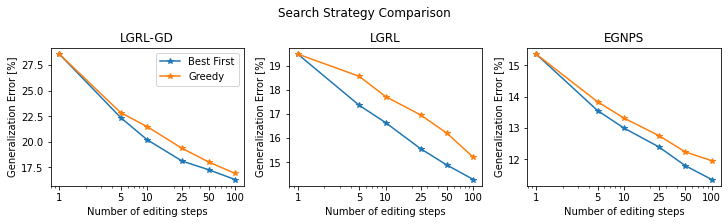

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
for ax, synthesizer in zip(axs, SYNTHESIZERS):
    ax.plot(K_VALS[:-1], generalization_errors(
        topline, synthesizer, True, True, "B"), marker='*',
            label="Best First")
    ax.plot(K_VALS[:-1], generalization_errors(
        topline, synthesizer, True, True, "G"), marker='*',
            label="Greedy")
    ax.set_title(to_display_name(synthesizer))
    ax.set_xlabel("Number of editing steps")
    ax.set_ylabel("Generalization Error [%]")
    ax.set_xscale('log')
    ax.set_xticks(K_VALS[:-1])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].legend()
fig.suptitle("Search Strategy Comparison")
plt.savefig("img/search_strategy_compare.png")

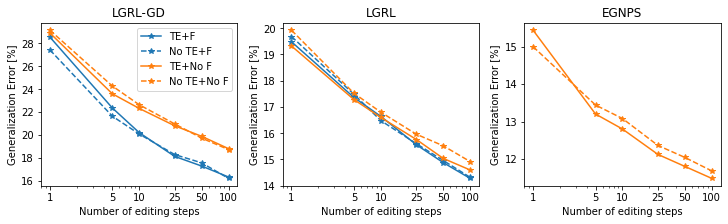

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
for ax, synthesizer in zip(axs, SYNTHESIZERS):
    if synthesizer.startswith("nearai"):
        ax.plot(K_VALS[:-1], generalization_errors(
            topline, synthesizer, True, True, "B"), marker='*', color=cycle[0],
                label="TE+F")
        ax.plot(K_VALS[:-1], generalization_errors(
            topline, synthesizer, False, True, "B"), marker='*', linestyle='--', color=cycle[0],
                label="No TE+F")
    ax.plot(K_VALS[:-1], generalization_errors(
        topline, synthesizer, True, False, "B"), marker='*', color=cycle[1],
            label="TE+No F")
    ax.plot(K_VALS[:-1], generalization_errors(
        topline, synthesizer, False, False, "B"), marker='*', linestyle='--', color=cycle[1],
            label="No TE+No F")
    ax.set_title(to_display_name(synthesizer))
    ax.set_xlabel("Number of editing steps")
    ax.set_ylabel("Generalization Error [%]")
    ax.set_xscale('log')
    ax.set_xticks(K_VALS[:-1])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].legend()
# fig.suptitle("Finetuning Comparison")
plt.savefig("img/arch_finetune_compare.png")

In [17]:
# # temporary for thesis draft
# plt.figure(figsize=(7, 5))
# plt.title("Val Results on Mutation Dataset")
# for model in "vanilla", "aggregate-standard", "aggregate-with-io":
#     plot_combined_accuracy(get_accuracies(model, 'eval'), model.replace('-', ' ').title())

# plt.xlim(5 * 10 ** 4, 10 ** 6)
# plt.ylabel("% of programs that pass all given test cases")
# plt.show()

In [18]:
# # temporary for thesis draft
# plt.figure(figsize=(7, 5))
# plt.title("Val Results on Mutation Dataset")
# for model in model_labels:
#     if "finetuned" in model and "1e-4" in model:
#         plot_combined_accuracy(get_accuracies(model, 'eval'), model.replace('-', ' ').title())

# plt.ylabel("% of programs that pass all given test cases")
# plt.show()
# plt.figure(figsize=(7, 5))
# plt.title("Val Results on Real Dataset")
# for model in model_labels:
#     if "finetuned" in model and "1e-4" in model:
#         plot_combined_accuracy(get_accuracies(model, 'real', 'nearai'), model.replace('-', ' ').title())

# plt.ylabel("% of programs that pass all given test cases")
# plt.show()

In [19]:
acs = accuracies
acs = by_max_acc(acs)
df = []
by_config = {}
by_config_ex = {}
for arch in "aggregate-with-io", "vanilla":
    for many_mutations in True, False:
        model = arch + "-many-mutations" * many_mutations
        gen_errors = []
        exact_errors = []
        for mut in range(1, 6):
            label = ",".join('0' * (mut - 1) + '1')
            row = acs[(acs.DataSource == 'eval') & (acs.Model == model) & (acs.DataLabel == label)]
            count = list(row.iterrows())
            assert len(count) <= 1
            if count == 0:
                res = float('nan'), float('nan')
            else:
                res = 100 * (1 - row.iloc[0].Accuracy), 100 * (1 - row.iloc[0].Exact)
            gen_errors.append(res[0])
            exact_errors.append(res[1])
            df.append([arch == "aggregate-with-io", many_mutations, mut, *res])
        by_config[arch=="aggregate-with-io", many_mutations] = gen_errors
        by_config_ex[arch=="aggregate-with-io", many_mutations] = exact_errors
df = pd.DataFrame(df, columns=["Trace?", "5 muts?", "# eval muts", "Gen Error", "Exact Error"])

In [20]:
def bar_chart_with_numbers(ax, xs, ys, width, *, hatch=None, label, color):
    ax.bar(xs, ys, width, hatch=hatch, label=label, color=color)
    for x, y in zip(xs, ys):
        ax.text(x - width * 0.3, y + 2, "{:.1f}".format(y), color=color, rotation=90, size=8, fontweight='bold')

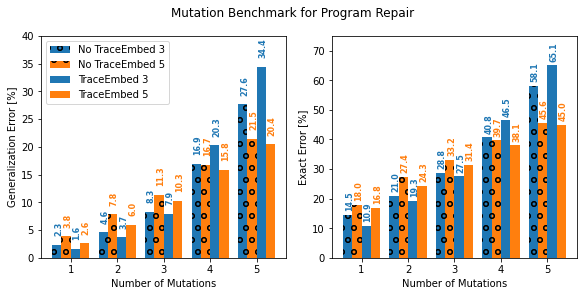

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=1)
bar_chart_with_numbers(ax1, np.arange(1, 6) - 0.3, by_config[False, False], 0.2, hatch='o',
         label="No TraceEmbed 3", color=cycle[0])
bar_chart_with_numbers(ax1, np.arange(1, 6) - 0.1, by_config[False, True], 0.2, hatch='o',
         label="No TraceEmbed 5", color=cycle[1])
bar_chart_with_numbers(ax1, np.arange(1, 6) + 0.1, by_config[True, False], 0.2,
         label="TraceEmbed 3", color=cycle[0])
bar_chart_with_numbers(ax1, np.arange(1, 6) + 0.3, by_config[True, True], 0.2,
         label="TraceEmbed 5", color=cycle[1])
ax1.legend()
ax1.set_ylim(0, 40)
ax1.set_xticks(range(1, 6))
ax1.set_xlabel("Number of Mutations")
ax1.set_ylabel("Generalization Error [%]")

bar_chart_with_numbers(ax2, np.arange(1, 6) - 0.3, by_config_ex[False, False], 0.2, hatch='o',
         label="No TraceEmbed on 3", color=cycle[0])
bar_chart_with_numbers(ax2, np.arange(1, 6) - 0.1, by_config_ex[False, True], 0.2, hatch='o',
         label="No TraceEmbed on 5", color=cycle[1])
bar_chart_with_numbers(ax2, np.arange(1, 6) + 0.1, by_config_ex[True, False], 0.2,
         label="TraceEmbed on 3", color=cycle[0])
bar_chart_with_numbers(ax2, np.arange(1, 6) + 0.3, by_config_ex[True, True], 0.2,
         label="TraceEmbed on 5", color=cycle[1])
ax2.set_ylim(0, 75)
ax2.set_xticks(range(1, 6))
ax2.set_xlabel("Number of Mutations")
ax2.set_ylabel("Exact Error [%]")
fig.suptitle("Mutation Benchmark for Program Repair")
plt.savefig("img/program_repair_benchmark.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
@lru_cache(None)
def get_distances(eval_path):
    with open(eval_path) as f:
        results = [json.loads(line) for line in f][1:]
    df = []
    for r in results:
        gold, ref, generated = r['example']['code'], r['example']['ref']['code'], r['code']['code_sequence']
        correct = r['stats']['correct'] == 6
        df.append([
            editdistance.eval(gold, ref),
            editdistance.eval(gold, generated),
            editdistance.eval(generated, ref),
            correct
        ])
    return pd.DataFrame(df, columns=["d(gold, ref)", "d(gold, pred)", "d(pred, ref)", "correct"])

In [23]:
path_fmt = "../logdirs/aggregate-with-io,trace_enc==aggregate:conv_all_grids=True,batch_size==64,lr==1,lr_decay_steps=100000/report-dev-m{}-1000100-{}.jsonl"

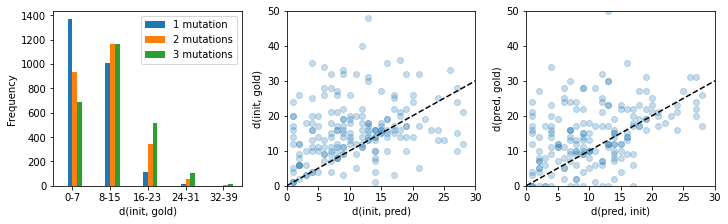

In [24]:
df = get_distances(path_fmt.format("nearai32,,best_first,,100,,start-with-beams", "real"))
fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
ax1.scatter(
    df[df.correct == 1]['d(pred, ref)'],
    df[df.correct == 1]['d(gold, ref)'],
    alpha=0.25
)
ax1.set_xlabel("d(init, pred)")
ax1.set_ylabel("d(init, gold)")
ax1.plot([0, 30], [0, 30], "--", color="black")
ax1.set_ylim(0, 50)
ax1.set_xlim(0, 30)
ax2.scatter(
    df[df.correct == 1]['d(pred, ref)'],
    df[df.correct == 1]['d(gold, pred)'],
    alpha=0.25
)
ax2.set_xlabel("d(pred, init)")
ax2.set_ylabel("d(pred, gold)")
ax2.plot([0, 30], [0, 30], "--", color="black")
ax2.set_ylim(0, 50)
ax2.set_xlim(0, 30)

interval = 8
maximum = 45
for nmut in 1, 2, 3:
    res = get_distances(path_fmt.format(",".join("0" * nmut + "1"), "eval"))
    res = res['d(gold, ref)']
    counts = Counter([x // interval for x in res])
    xvals = np.arange(0, maximum // interval) * interval + interval / 2
    ax3.bar(
        xvals + nmut - 1.5,
        np.array([counts[x] for x in range(maximum // interval)]),
        width=1,
        label="{} mutation{}".format(nmut, (nmut > 1) * "s"),
    )
ax3.legend()
ax3.set_xlim(0, 40)
ax3.set_xticks(xvals)
ax3.set_xticklabels(["{:.0f}-{:.0f}".format(x - interval/2, x + interval/2 - 1) for x in xvals])
ax3.set_xlabel("d(init, gold)")
ax3.set_ylabel("Frequency")
plt.savefig("img/mutations_info.png")